# 3DVar

In [38]:
import autoroot
from pathlib import Path
import numpyro
import numpyro.distributions as dist
from jax import config
config.update("jax_enable_x64", True)
import einx
import jax
import jax.numpy as jnp
import numpy as np
import jax.random as jr
import xarray as xr
from jaxtyping import Float, Array
import cola
from oi_toolz._src.ops.kernels import kernel_rbf, gram
from oi_toolz._src.ops.linalg import create_psd_matrix
from oi_toolz._src.ops.varda import (
    linear_3dvar_model_space,
    linear_3dvar_model_space_incremental,
    linear_3dvar_obs_space_incremental
)
from cola.linalg import Auto
from oi_toolz._src.ops.enskf import analysis_etkf
from sklearn.datasets import make_spd_matrix, make_sparse_spd_matrix

key = jr.key(123)

import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.75)


%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data

In [41]:
num_dims_x = 100
num_dims_y = 50

key, *subkeys = jr.split(key, 5)

# observations
y = jr.normal(subkeys[0], shape=(num_dims_y,))

# observation operator
H = jr.normal(subkeys[1], shape=(num_dims_y, num_dims_x))

# prior parameters
mu_x = jnp.ones(shape=(num_dims_x,))
Sigma_x = make_sparse_spd_matrix(n_dim=num_dims_x, sparse_format="csr")
# Sigma_x = cola.ops.Sparse(data=Sigma_x.data, indices=Sigma_x.indices, indptr=Sigma_x.indptr, shape=Sigma_x.shape)
Sigma_x = cola.ops.Dense(make_spd_matrix(n_dim=num_dims_x, random_state=5))

# observation
Sigma_y = cola.ops.Dense(make_spd_matrix(n_dim=num_dims_y, random_state=5))
# Sigma_y = cola.ops.Diagonal(cola.diag(Sigma_y))

## Formulation



$$
\begin{aligned}
\boldsymbol{J}(\mathbf{u}) &= ||\boldsymbol{y}-\boldsymbol{h}(\boldsymbol{u})||_{\boldsymbol{\Sigma_y}^{-1}}^2
+ ||\boldsymbol{u}-\boldsymbol{\mu_u}||_{\boldsymbol{\Sigma_u}^{-1}}^2
\end{aligned}
$$

#### **Model-Space**

$$
\mathbf{u} = 
\left(\boldsymbol{\Sigma_u} + \mathbf{H}^\top\boldsymbol{\Sigma_y}^{-1}\mathbf{H}\right)^{-1}
\left(\boldsymbol{\Sigma_u}^{-1}\boldsymbol{\mu_u} + \mathbf{H}^\top\boldsymbol{\Sigma_y}^{-1}\mathbf{y}\right)
$$

In [42]:
u = linear_3dvar_model_space(y=y, H=H, mu_x=mu_x, Sigma_x=Sigma_x, Sigma_y=Sigma_y)
u.shape

(100,)

#### **Model-Space Incremental**

$$
\mathbf{u} = 
\boldsymbol{\mu_u} + 
\left( 
\boldsymbol{\Sigma_u}^{-1} + 
\mathbf{H}^\top\boldsymbol{\Sigma_y}^{-1}\mathbf{H}\right)^{-1}
\mathbf{H}^\top\boldsymbol{\Sigma_y}^{-1}
\left(\mathbf{y} -\mathbf{H}\boldsymbol{\mu_u}\right)
$$

In [43]:
u2 = linear_3dvar_model_space_incremental(y=y, H=H, mu_x=mu_x, Sigma_x=Sigma_x, Sigma_y=Sigma_y)
u2.shape

(100,)

In [44]:
np.testing.assert_array_almost_equal(u, u2)

#### **Observation-Space**

We can use the Sherman-Morrison-Woodbury inversion formula to change the way we do this.

$$
\mathbf{u} = 
\boldsymbol{\mu_u} + 
\boldsymbol{\Sigma_u}\mathbf{H}^\top
\left(\boldsymbol{\Sigma_y} + \mathbf{H}\boldsymbol{\Sigma_u}\mathbf{H}^\top\right)^{-1}
\left(\mathbf{y} -\mathbf{H}\boldsymbol{\mu_u}\right)
$$

In [45]:
u3 = linear_3dvar_obs_space_incremental(y=y, H=H, mu_x=mu_x, Sigma_x=Sigma_x, Sigma_y=Sigma_y)
u3.shape

(100,)

In [46]:
np.testing.assert_array_almost_equal(u2, u3)

In [47]:
# %%timeit

# linear_3dvar_model_space(y=y, H=H, mu_x=mu_x, Sigma_x=Sigma_x, Sigma_y=Sigma_y).block_until_ready()


In [48]:
# %%timeit

# linear_3dvar_model_space_incremental(y=y, H=H, mu_x=mu_x, Sigma_x=Sigma_x, Sigma_y=Sigma_y)

In [49]:
# %%timeit

# linear_3dvar_obs_space_incremental(y=y, H=H, mu_x=mu_x, Sigma_x=Sigma_x, Sigma_y=Sigma_y)

## Example

In [50]:
import equinox as eqx
import diffrax as dfx

In [51]:
data = xr.open_dataset("/Users/eman/code_projects/data/pyda/lorenz63/l63_sim.nc")

In [52]:
data

<xarray.Dataset>
Dimensions:             (time: 1001, component: 3)
Coordinates:
  * time                (time) float32 0.0 0.01 0.02 0.03 ... 9.98 9.99 10.0
  * component           (component) <U1 'x' 'y' 'z'
Data variables:
    simulation          (component, time) float32 ...
    observations        (component, time) float32 ...
    observations_noisy  (component, time) float64 ...

### Dynamical System

In [53]:
from oi_toolz._src.models.l63 import L63Params, L63State, l63_equation_of_motion

#### Observation Operator

In [54]:
def obs_op(u):
    return u

def obs_op_der(u):
    return jnp.eye(u.shape[0])

#### Parameters

In [55]:
num_dim_x = num_dim_y = 3

params = L63Params(
    sigma=data.simulation.attrs["sigma"].astype(np.float64),
    rho=data.simulation.attrs["rho"].astype(np.float64),
    beta=data.simulation.attrs["beta"].astype(np.float64),
)

sigma_y = 0.15
R = sigma_y**2 * cola.ops.Diagonal(jnp.ones(num_dim_y))
H = jnp.eye(num_dim_y)

In [56]:
ts = data.time.values
dt = ts[1] - ts[0]

In [57]:
from tqdm.auto import tqdm

In [58]:
data["ts_diff"] = data.time.diff("time")

dt = data["ts_diff"].values[1]

In [59]:
dt

0.01

### Missing Data

In [60]:
dt_obs = 0.2
t_max_obs = 5
t_steps_obs = int(t_max_obs/dt_obs)

In [61]:
ind_obs = np.linspace(int(dt_obs/dt), int(t_max_obs/dt), t_steps_obs).astype(int)

In [62]:
data["observations"] =  xr.full_like(data["simulation"], np.nan)
data["observations"][:, ind_obs] = data["simulation"][:, ind_obs]

#### Noise

In [63]:
rng = np.random.RandomState(123)
sigma_y = 0.15

noise =  sigma_y**2 * rng.randn(*data["observations"].shape)

data["observations_noisy"] = data["observations"] + noise

In [64]:
noise

array([[-0.02442669,  0.02244027,  0.00636702, ...,  0.01058093,
        -0.02500719, -0.01684862],
       [ 0.01277088,  0.01615839, -0.02248607, ...,  0.00030533,
        -0.03992003, -0.02703099],
       [ 0.02466578,  0.01937333, -0.03420826, ..., -0.01013847,
         0.01371578,  0.02640925]])

In [65]:
# initial parameters
mu_u = jnp.asarray([2.0, 3.0, 4.0])
sigma_x = cola.ops.Diagonal(0.1*jnp.ones(3))
sigma_y = cola.ops.Diagonal(0.15*jnp.ones(3))

In [66]:
solver = dfx.Tsit5()
stepsize_controller = dfx.PIDController(rtol=1e-7, atol=1e-7)

In [67]:
data["predictions"] = np.nan * data["simulation"]

In [68]:
data["predictions"]

<xarray.DataArray 'predictions' (component: 3, time: 1001)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * time       (time) float32 0.0 0.01 0.02 0.03 0.04 ... 9.97 9.98 9.99 10.0
  * component  (component) <U1 'x' 'y' 'z'

In [69]:
solver = dfx.Euler() #dfx.Tsit5() #  
stepsize_controller = dfx.ConstantStepSize() #dfx.PIDController(rtol=1e-7, atol=1e-7)

In [104]:
def kf_update(y, Sigma_y, H, mu_u, Sigma_u, inv_alg=Auto()):
    
    # compute Kalman Gain
    D = cola.ops.Dense(H @ Sigma_u.to_dense() @ H.T - Sigma_y.to_dense())
    K = Sigma_u @ H @ cola.inv(D, alg=inv_alg)
    K = cola.ops.Dense(K)
    
    # compute analysis
    ua = mu_u + K @ (y - H @ mu_u)
    P = cola.ops.I_like(Sigma_u) - K @ H @ Sigma_u
    
    return ua, P

In [102]:
ua, _ = kf_update(y, sigma_y, H, mu_u, sigma_x)
ua.shape

[[-2.  0.  0.]
 [ 0. -2.  0.]
 [ 0.  0. -2.]]
[nan nan nan]


(3,)

In [70]:
for iteration, (itime, ids) in tqdm(enumerate(list(data.groupby("time")))):
    

    if iteration == 0:
        # use this as background state for next iteration
        mu_u = ids.simulation.values
        # continue the loop
        continue
    
    # use previous background state to make prediction
    u = L63State(
        x=mu_u[0],
        y=mu_u[1],
        z=mu_u[2]
    )

    
    itime = itime.astype(np.float64)
    # do forward prediction
    sol = dfx.diffeqsolve(
        terms=dfx.ODETerm(l63_equation_of_motion),
        t0=itime,
        t1=itime + dt,
        dt0=dt,
        y0=u,
        args=params,
        solver=solver,
        stepsize_controller=stepsize_controller,
    )
    # extract array from state
    mu_u = sol.ys.to_array().squeeze()
    
    # if we dont have observations (do analysis)
    y = ids.observations_noisy.values
    
    if np.sum(np.isnan(y)):
        # if there are no observations no analysis
        mu_a = mu_u.copy()
    else:
        # if there no observations - do analysis
        mu_a = linear_3dvar_obs_space_incremental(y, H, sigma_y, mu_u, sigma_x)
        
    # if we do have observations (don't do analysis)
    data["predictions"][:, iteration] = mu_a
    mu_u = mu_a.copy()

0it [00:00, ?it/s]

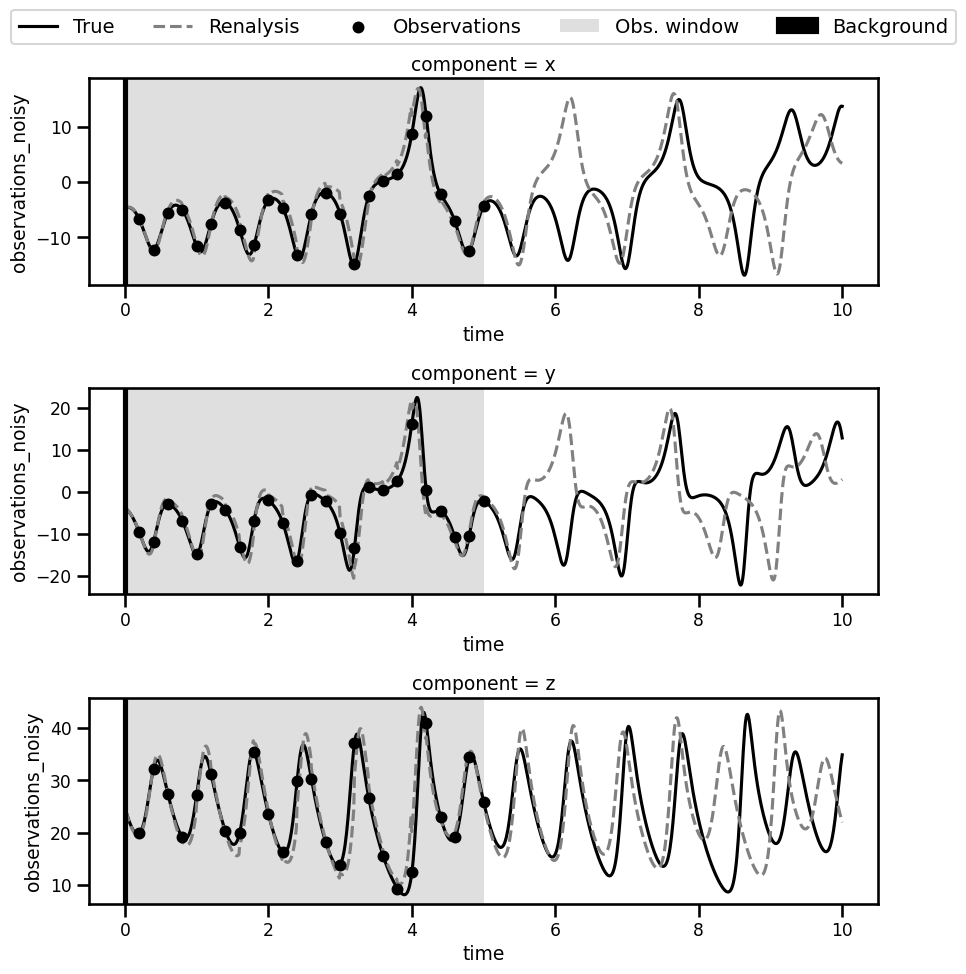

In [73]:
fig, ax = plt.subplots(nrows=3, figsize=(10, 10))

# Plot Simulation Data
data.simulation.sel(component="x").plot(ax=ax[0], color="black", label="True")
data.simulation.sel(component="y").plot(ax=ax[1], color="black", label="True")
data.simulation.sel(component="z").plot(ax=ax[2], color="black", label="True")

# plot Reanalysis Data
data.predictions.sel(component="x").plot(ax=ax[0], color="gray", linestyle="--", label="Renalysis")
data.predictions.sel(component="y").plot(ax=ax[1], color="gray", linestyle="--", label="Renalysis")
data.predictions.sel(component="z").plot(ax=ax[2], color="gray", linestyle="--", label="Renalysis")


data.observations_noisy.sel(component="x").plot.scatter(ax=ax[0], zorder=3, color="black", marker=".", s=200, label="Observations")
data.observations_noisy.sel(component="y").plot.scatter(ax=ax[1], zorder=3, color="black", marker=".", s=200, label="Observartions")
data.observations_noisy.sel(component="z").plot.scatter(ax=ax[2], zorder=3, color="black", marker=".", s=200, label="Observartions")

# Draw Observation Window
ax[0].axvspan(0 + dt, t_max_obs, color="gray", alpha=0.25, lw=0, label="Obs. window")
ax[1].axvspan(0 + dt, t_max_obs, color="gray", alpha=0.25, lw=0, label="Obs. window")
ax[2].axvspan(0 + dt, t_max_obs, color="gray", alpha=0.25, lw=0, label="Obs. window")

# Draw Background Window
ax[0].axvspan(0, dt, color="black", lw=3, zorder=5, label="Background")
ax[1].axvspan(0, dt, color="black", lw=3, zorder=5, label="Background")
ax[2].axvspan(0, dt, color="black", lw=3, zorder=5, label="Background")

# create Legend
ax[0].legend(loc="center", bbox_to_anchor=(0.5, 1.25), fontsize=14, ncols=5,)

plt.tight_layout()
plt.show()